In [203]:
import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [204]:
def load_data(data, label):
    for file in os.listdir(label):
        if file.endswith('.txt') and not file.startswith('.'):
            file_path = label + '/' + file
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                data[text] = label
df = {}
load_data(df, 'default')
default_num = len(df)
load_data(df, 'ndefault')
print("Totoal doc:", len(df))
print("Number of doc in default group:", default_num)
print("Number of doc in ndefault group:", len(df)-default_num)
X_train = []
Y_train = []
for doc in df:
    X_train.append(doc)
    Y_train.append(df[doc])

Totoal doc: 85
Number of doc in default group: 30
Number of doc in ndefault group: 55


In [147]:
random.seed(888)
train_df = {}
test_df = {}
split = random.sample(list(df), k=int(len(df)*0.65))
for s in split:
    train_df[s] = df[s]
for text in df:
    if text not in train_df:
        test_df[text] = df[text]
print(len(train_df), len(test_df))

55 30


In [148]:
n_features = 1000
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
# count_vec = CountVectorizer(max_df=0.9, min_df=3,
#                             max_features=n_features,
#                             stop_words='english')
tfidf_vectorizer = TfidfVectorizer(max_df=0.65, min_df=12,
                                   max_features=n_features, ngram_range = (2,2), norm='l1',
                                   stop_words='english')

In [149]:
#x_train_counts = count_vec.fit_transform(train_df)
x_train = tfidf_vectorizer.fit_transform([text for text in train_df])
y_train = [train_df[t] for t in train_df]
x_test = tfidf_vectorizer.transform([text for text in test_df])

In [ ]:
# Naive Bayes Classifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
nb_clf = MultinomialNB(alpha=0.9)
nb_clf.fit(x_train, y_train)

In [ ]:
nb_predicted = nb_clf.predict(x_test)

In [ ]:
y_test = [test_df[t] for t in test_df]
eval_len = len(nb_predicted)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, nb_predicted))

In [ ]:
# SVM
from sklearn import svm
svm_clf = svm.SVC(gamma='scale', kernel='sigmoid', probability=True)

svm_clf.fit(x_train, y_train)

In [ ]:
svm_predicted = svm_clf.predict(x_test)
print(metrics.classification_report(y_test, svm_predicted))

In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=3000, criterion='entropy', max_features=None, class_weight='balanced')
rf_clf.fit(x_train, y_train)
rf_predicted = rf_clf.predict(x_test)
print(metrics.classification_report(y_test, rf_predicted))

In [ ]:
from sklearn.neighbors import NearestCentroid
nc_clf = NearestCentroid(metric='manhattan')
nc_clf.fit(x_train, y_train)
nc_predicted = nc_clf.predict(x_test)
print(metrics.classification_report(y_test, nc_predicted))

In [ ]:
#unknown_predict = svm_clf.predict_proba(x_unknown)

In [ ]:
y_test

In [ ]:
import numpy as np
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    #score = metrics.f1_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    print(metrics.classification_report(y_test, pred))
    
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [ ]:
# Train NearestCentroid without threshold
results = []
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid(metric='manhattan')))

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
import math
first_vector_tfidfvectorizer=x_train[0]

df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(n=50)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(tfidf_vectorizer.vocabulary_)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [235]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
kf = RepeatedStratifiedKFold(n_splits=3)

data = pd.DataFrame(list(df.items()), columns=['text', 'class'])

In [236]:
clf_eval = pd.DataFrame(columns=['f1 score for default', 'accuracy'])

In [246]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
# from sklearn.model_selection import GridSearchCV
# parameters = {'ngram_range': [(1, 1), (2, 2)],
#               'use_idf': (True, False),
#               'clf__alpha': (1e-2, 1e-3)
#              }
f1scores = []
acus = []
t0 = time()
clf_eval = pd.DataFrame(columns=['recall for default', 'accuracy'])
for train_idx, test_idx in kf.split(X_train, Y_train):
    text_clf = Pipeline([('vect', TfidfVectorizer(max_features=350, max_df=0.9, min_df=8, sublinear_tf=True,
                                              ngram_range = (2,2), norm='l1', stop_words='english')),
                         ('clf', NearestCentroid('euclidean')),
                        ])
    train_text = data.iloc[train_idx]['text'].values
    train_y = data.iloc[train_idx]['class'].values

    test_text = data.iloc[test_idx]['text'].values
    test_y = data.iloc[test_idx]['class'].values

    text_clf.fit(train_text, train_y)
    predictions = text_clf.predict(test_text)

    # Compute accuracy
    print(metrics.classification_report(test_y, predictions))
    score = f1_score(test_y, predictions, pos_label='default')
    f1scores.append(score)
    acus.append(accuracy_score(test_y, predictions))
    
print("train time: %0.3fs" % (time() - t0))

              precision    recall  f1-score   support

     default       1.00      0.20      0.33        10
    ndefault       0.70      1.00      0.83        19

    accuracy                           0.72        29
   macro avg       0.85      0.60      0.58        29
weighted avg       0.81      0.72      0.66        29

              precision    recall  f1-score   support

     default       0.83      1.00      0.91        10
    ndefault       1.00      0.89      0.94        18

    accuracy                           0.93        28
   macro avg       0.92      0.94      0.93        28
weighted avg       0.94      0.93      0.93        28

              precision    recall  f1-score   support

     default       0.80      0.40      0.53        10
    ndefault       0.74      0.94      0.83        18

    accuracy                           0.75        28
   macro avg       0.77      0.67      0.68        28
weighted avg       0.76      0.75      0.72        28

              preci

              precision    recall  f1-score   support

     default       0.67      0.40      0.50        10
    ndefault       0.73      0.89      0.80        18

    accuracy                           0.71        28
   macro avg       0.70      0.64      0.65        28
weighted avg       0.71      0.71      0.69        28

              precision    recall  f1-score   support

     default       0.67      0.40      0.50        10
    ndefault       0.74      0.89      0.81        19

    accuracy                           0.72        29
   macro avg       0.70      0.65      0.65        29
weighted avg       0.71      0.72      0.70        29

              precision    recall  f1-score   support

     default       1.00      0.50      0.67        10
    ndefault       0.78      1.00      0.88        18

    accuracy                           0.82        28
   macro avg       0.89      0.75      0.77        28
weighted avg       0.86      0.82      0.80        28

              preci

In [245]:
f1 = np.array(f1scores)
accuracy = np.array(acus)
print(f1.mean())
print(accuracy.mean())

0.6086898062278329
0.7550492610837435


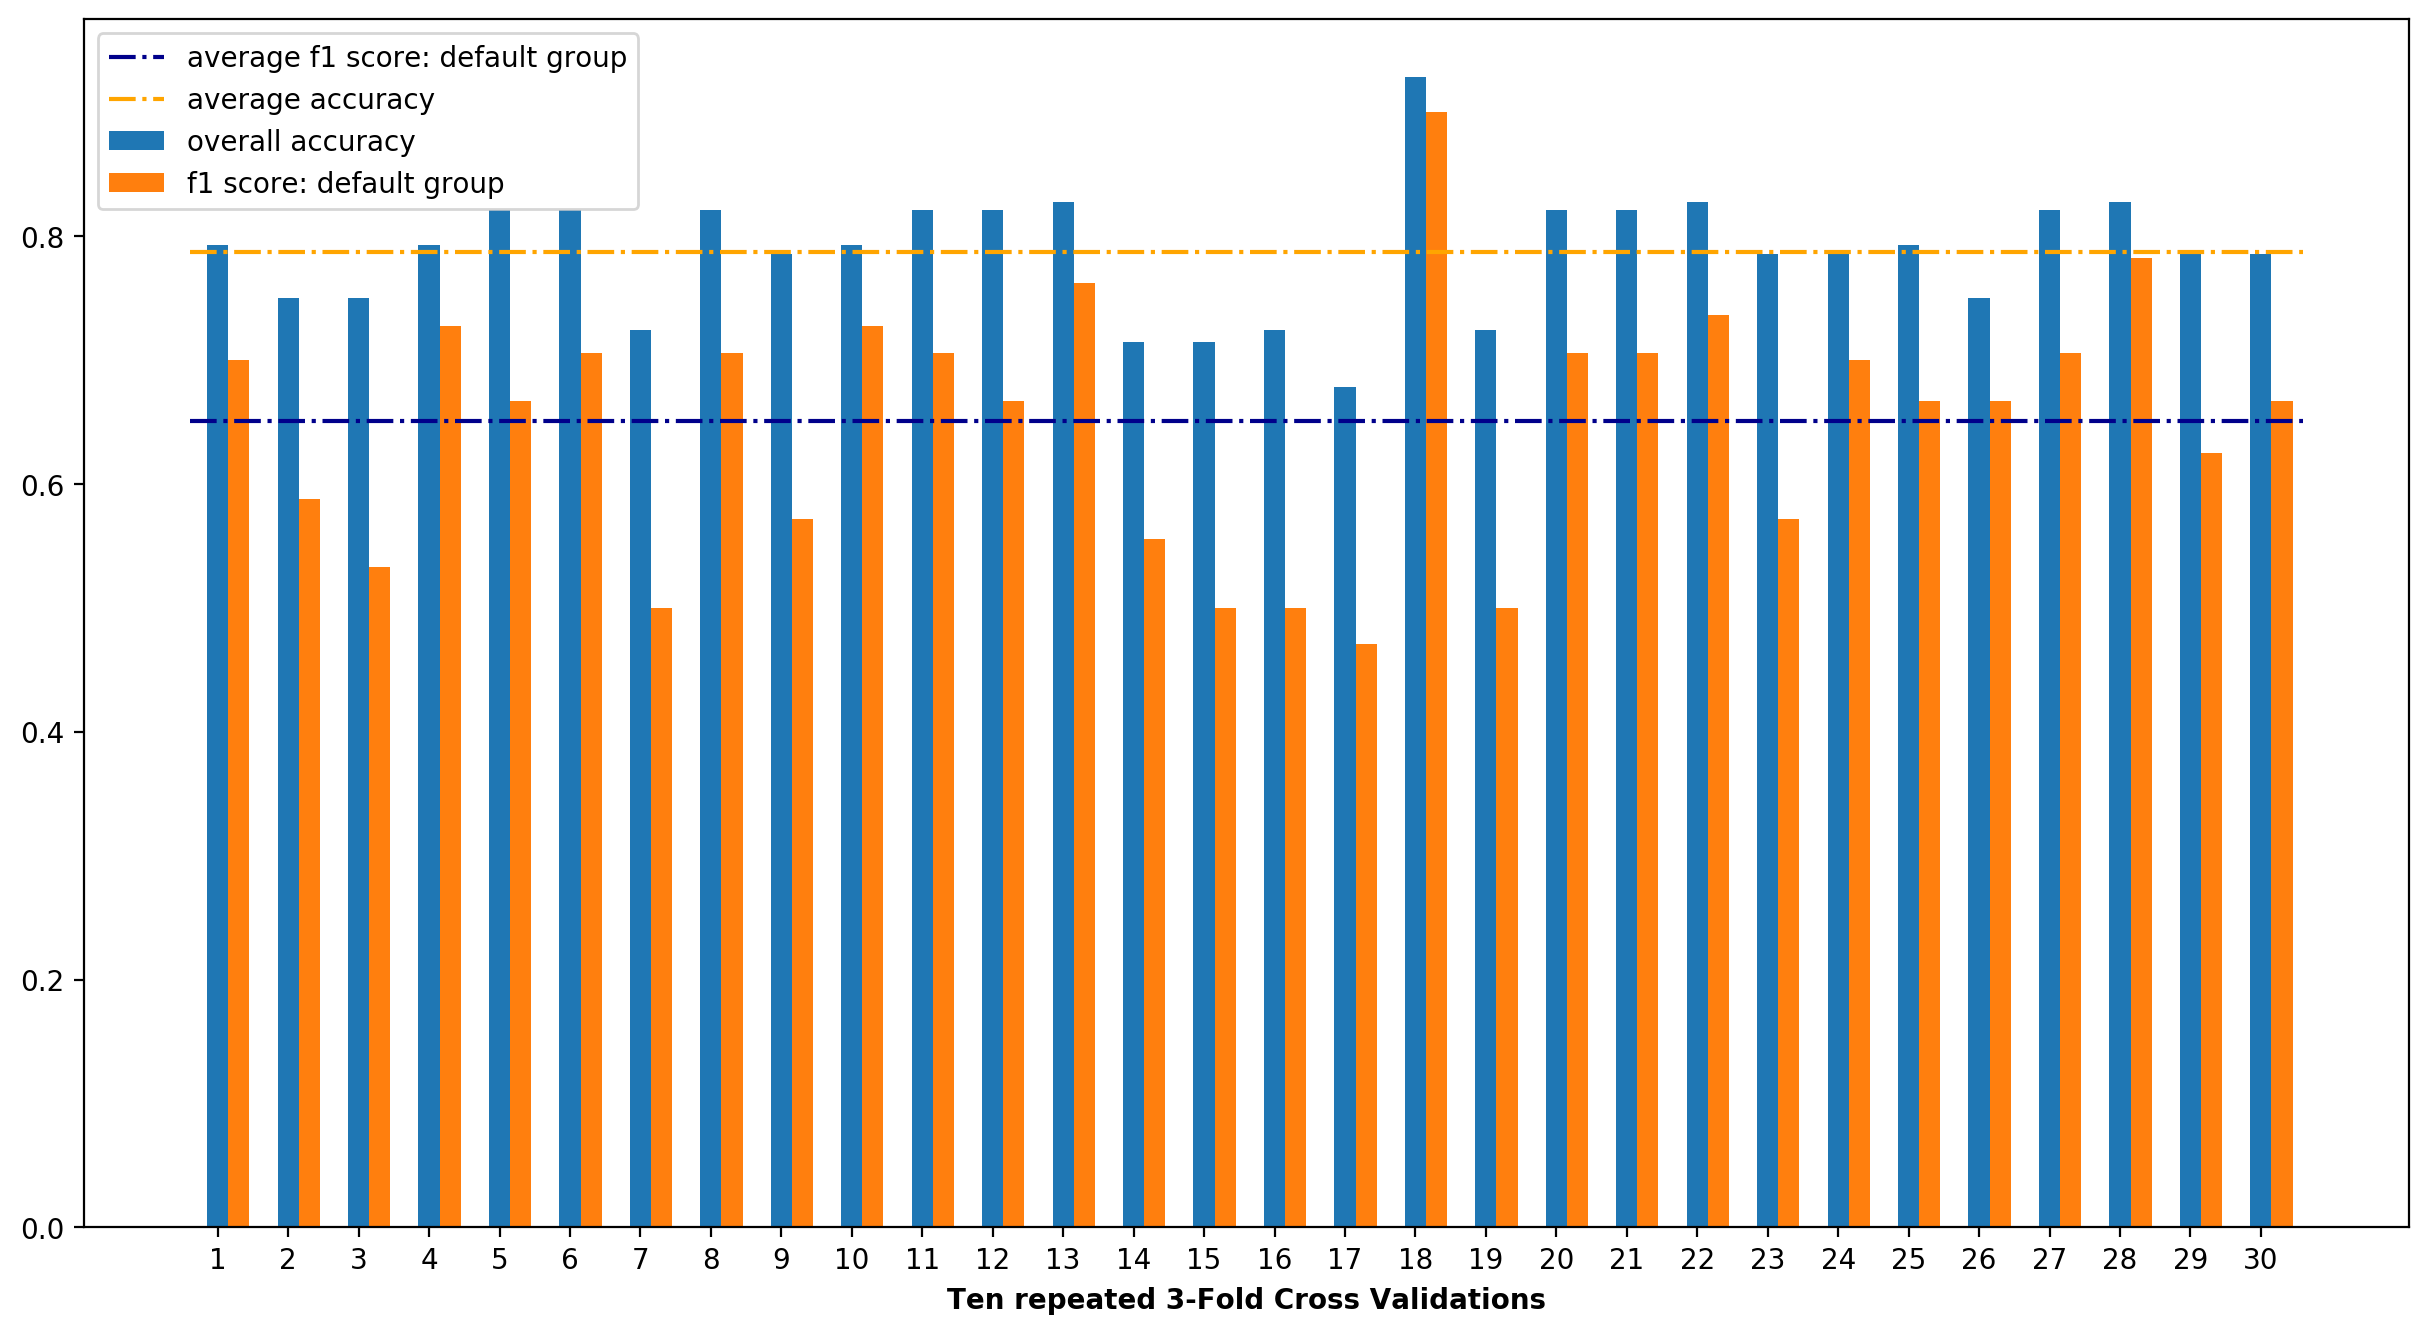

In [229]:
import matplotlib.pyplot as plt
barWidth = 0.3
x1 = np.arange(30)
x2 = [x + barWidth for x in x1]
plt.figure(figsize=(15,8), dpi=200)
plt.bar(x1, acus, width=barWidth, label='overall accuracy', )
plt.bar(x2, f1scores, width=barWidth, label='f1 score: default group')
plt.hlines(f1.mean(), xmin=-0.4, xmax=29.6, color='darkblue', linestyles='dashdot', label='average f1 score: default group')
plt.hlines(accuracy.mean(), xmin=-0.4, xmax=29.6, color='orange', linestyles='dashdot', label='average accuracy')
plt.xlabel('Ten repeated 3-Fold Cross Validations', fontweight='bold')
plt.xticks(x1, [str(x+1) for x in x1])
plt.legend()
plt.show()

In [247]:
voc = pd.DataFrame(list(text_clf['vect'].vocabulary_.items()), columns=['features', 'count'])
voc['idf'] = text_clf['vect'].idf_

In [248]:
len(text_clf['vect'].vocabulary_)

350

In [249]:
voc.sort_values(by=["idf"],ascending=False).head(n=20)

,features,count,idf
108,make sense,169,2.863218
202,approximately million,26,2.863218
126,cost reduction,61,2.863218
131,foreign currency,94,2.863218
209,diluted share,72,2.863218
93,low level,165,2.863218
203,deliver strong,70,2.863218
221,yes mean,348,2.863218
320,12 month,5,2.863218
201,continue work,60,2.757858


In [175]:
(n_classes, n_features) = text_clf['clf'].centroids_

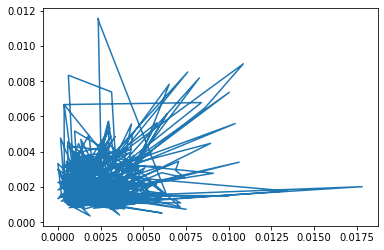

In [186]:
plt.plot(n_classes, n_features)

In [202]:
import re

ttt = " thanks Mike and good morning everyone ."
re.sub(r'good morning( everyone)*', '', ttt)

' thanks Mike and  .'